# SPSS Modelerの決定木ノードをPythonで書き換える。信用リスクの判定


以下のようなデータを用いて決定木モデルを作ります。

目的変数
Credit_rating：信用リスク

説明変数
Age：年齢
Income：収入ランク
Credit_cards：クレジットカード枚数
Education：学歴
Car_loans:車のローン数

![image.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/223763/1f0049e8-65ac-26c0-41d8-a670f9e1eb6e.png)

年齢や収入ランクから信用リスクを判定するモデルを作ります。

In [1]:
#必要に応じて以下を導入してください。
#conda install graphviz
#conda install pydotplus
#!pip install sklearn.externals
#!pip install graphviz
#conda install category_encoders


In [2]:
!wget https://github.com/hkwd/200611Modeler2Python/raw/master/data/tree_credit.csv

'wget' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [3]:
#データの読み込み
import types
import pandas as pd
import numpy as np

pd.options.display.max_rows = 10
#print(pd.options.display.max_rows)

import pandas as pd
df = pd.read_csv('tree_credit.csv')
print(df.dtypes)
df

Credit_rating     object
Age              float64
Income            object
Credit_cards      object
Education         object
Car_loans         object
dtype: object


,Credit_rating,Age,Income,Credit_cards,Education,Car_loans
0,Bad,36.220,Medium,5 or more,College,More than 2
1,Bad,21.990,Medium,5 or more,College,More than 2
2,Bad,29.170,Low,5 or more,High school,More than 2
3,Bad,32.753,Low,5 or more,College,None or 1
4,Bad,36.771,Medium,5 or more,College,More than 2
...,...,...,...,...,...,...
2459,Good,27.848,Medium,Less than 5,High school,None or 1
2460,Good,29.533,Medium,Less than 5,College,None or 1
2461,Good,23.642,Medium,Less than 5,High school,None or 1
2462,Good,45.524,Medium,5 or more,College,More than 2


In [4]:
from sklearn.preprocessing import LabelEncoder

#目的変数のエンコード
le = LabelEncoder()
y  = le.fit_transform(df['Credit_rating'].values)
print(le.classes_)
print(type(df['Credit_rating'].values))
print(type(y))
print(y)


['Bad' 'Good']
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[0 0 0 ... 1 1 1]


In [5]:
#カテゴリ変数のコード化
import category_encoders as ce
#説明変数のエンコード
ce_oe = ce.OrdinalEncoder(cols=['Income','Credit_cards', 'Education', 'Car_loans'],
                          handle_unknown='impute')
X  = ce_oe.fit_transform(df)[['Age','Income', 'Credit_cards', 'Education', 'Car_loans']]
X.head()

,Age,Income,Credit_cards,Education,Car_loans
0,36.220,1,1,1,1
1,21.990,1,1,1,1
2,29.170,2,1,2,1
3,32.753,2,1,1,2
4,36.771,1,1,1,1


Category Encodersでカテゴリ特徴量をストレスなく変換する - Qiita
https://qiita.com/Hyperion13fleet/items/afa49a84bd5db65ffc31

In [6]:
import pprint
pprint.pprint(ce_oe.mapping)


[{'col': 'Income',
  'data_type': dtype('O'),
  'mapping': Medium    1
Low       2
High      3
NaN      -2
dtype: int64},
 {'col': 'Credit_cards',
  'data_type': dtype('O'),
  'mapping': 5 or more      1
Less than 5    2
NaN           -2
dtype: int64},
 {'col': 'Education',
  'data_type': dtype('O'),
  'mapping': College        1
High school    2
NaN           -2
dtype: int64},
 {'col': 'Car_loans',
  'data_type': dtype('O'),
  'mapping': More than 2    1
None or 1      2
NaN           -2
dtype: int64}]


In [7]:
#IncomeのエンコードがMedium<Low<Highの順序なのでLow<Medium<Highの順序に修正
ce_oe.mapping[0]['mapping']={None: 0, 'Low': 1, 'Medium': 2, 'High': 3}
pprint.pprint(ce_oe.mapping)

[{'col': 'Income',
  'data_type': dtype('O'),
  'mapping': {None: 0, 'High': 3, 'Low': 1, 'Medium': 2}},
 {'col': 'Credit_cards',
  'data_type': dtype('O'),
  'mapping': 5 or more      1
Less than 5    2
NaN           -2
dtype: int64},
 {'col': 'Education',
  'data_type': dtype('O'),
  'mapping': College        1
High school    2
NaN           -2
dtype: int64},
 {'col': 'Car_loans',
  'data_type': dtype('O'),
  'mapping': More than 2    1
None or 1      2
NaN           -2
dtype: int64}]


In [8]:
#修正したマッピングで変換しなおす
X  = ce_oe.fit_transform(df)[['Age','Income', 'Credit_cards', 'Education', 'Car_loans']]
X.head()

,Age,Income,Credit_cards,Education,Car_loans
0,36.220,2,1,1,1
1,21.990,2,1,1,1
2,29.170,1,1,2,1
3,32.753,1,1,1,2
4,36.771,2,1,1,1


In [9]:
#Cartモデル作成のパッケージ
from sklearn.tree import DecisionTreeClassifier
#モデル作成
clf = DecisionTreeClassifier(max_depth=5,min_samples_split=0.02,min_samples_leaf=0.01,min_impurity_decrease=0.0001)
clf = clf.fit(X, y)

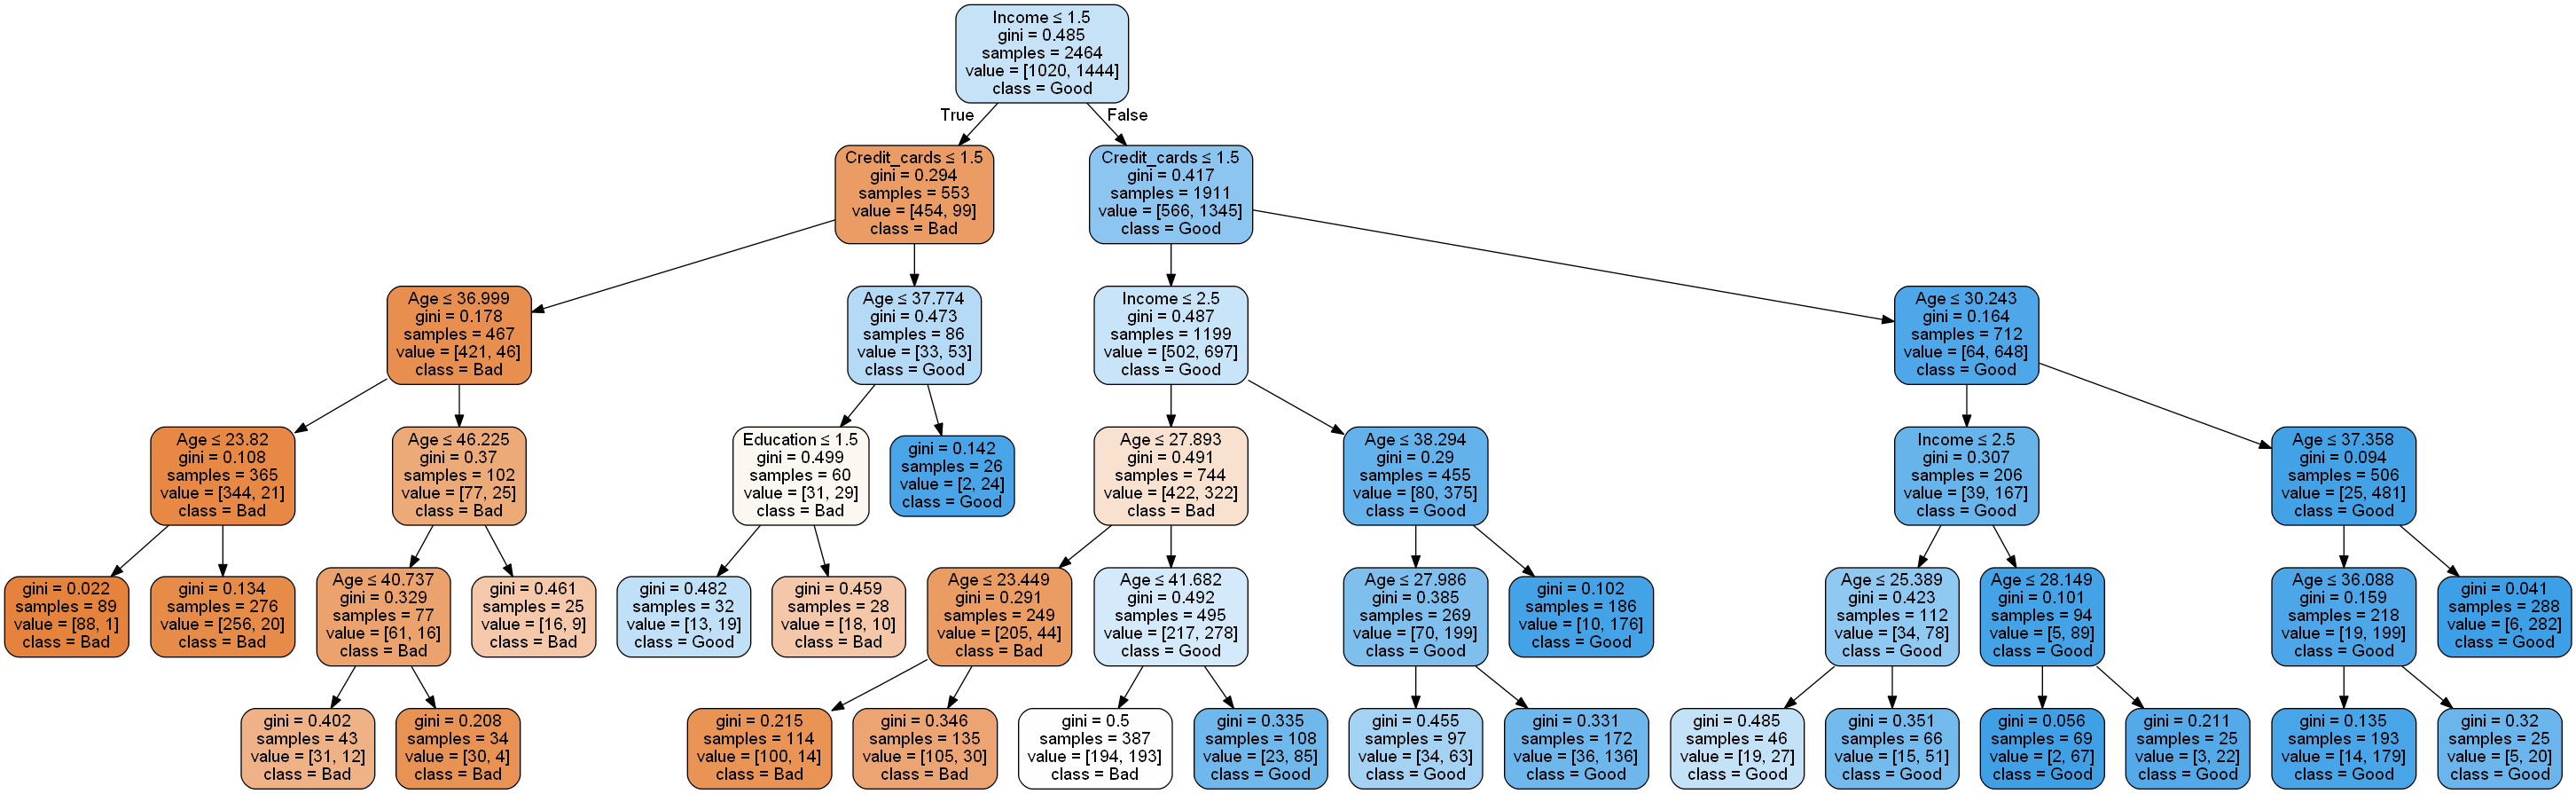

In [10]:
#決定木表示
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf, out_file=dot_data,  
                     feature_names=['Age','Income', 'Credit_cards', 'Education', 'Car_loans'], 
                     class_names=le.classes_,  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [11]:
print(clf.predict(X))
print(type(clf.predict(X)))
print(clf.predict_proba(X))
print(type(clf.predict_proba(X)))

[0 0 0 ... 1 1 1]
<class 'numpy.ndarray'>
[[0.50129199 0.49870801]
 [0.87719298 0.12280702]
 [0.92753623 0.07246377]
 ...
 [0.41304348 0.58695652]
 [0.21296296 0.78703704]
 [0.12       0.88      ]]
<class 'numpy.ndarray'>


In [12]:

df_pred = df.copy()
#予測結果を追加
df_pred['$Credit_rating']=le.inverse_transform(clf.predict(X))
#予測結果の確信度を追加
df_pred['$RC-Credit_rating']=clf.predict_proba(X).max(axis=1)
#予測結果の傾向スコアを追加
#df_pred['$RP-Credit_rating']=clf.predict_proba(X)[:,1]
df_pred.head(20)

,Credit_rating,Age,Income,Credit_cards,Education,Car_loans,$Credit_rating,$RC-Credit_rating
0,Bad,36.220,Medium,5 or more,College,More than 2,Bad,0.501292
1,Bad,21.990,Medium,5 or more,College,More than 2,Bad,0.877193
2,Bad,29.170,Low,5 or more,High school,More than 2,Bad,0.927536
3,Bad,32.753,Low,5 or more,College,None or 1,Bad,0.927536
4,Bad,36.771,Medium,5 or more,College,More than 2,Bad,0.501292
...,...,...,...,...,...,...,...,...
15,Bad,39.456,Low,5 or more,College,More than 2,Bad,0.720930
16,Bad,34.127,Low,5 or more,College,More than 2,Bad,0.927536
17,Bad,35.818,Medium,5 or more,College,More than 2,Bad,0.501292
18,Bad,35.966,Medium,5 or more,College,More than 2,Bad,0.501292


In [13]:
import sys

print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [14]:
print(pd.__version__)

1.0.5


In [15]:
import sklearn

print(sklearn.__version__)

0.23.2


In [16]:
print(ce.__version__)

2.2.2


In [17]:
print(graphviz.__version__)

0.17
